# Modeling

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from imblearn.over_sampling import SMOTE #Over sampling
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 10
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in last phase
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
# Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data['loan_status'].apply(lambda x: True if (x == 'Charged Off' or x == 'Default') else False)

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because 
# we will be fitting a variety of models on various time periods, 
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], data.shape[0], p = [0.7, 0.3])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

**Note:** Since data is imbalanced (Non-default:default = 5:1), here we modify the data to up sample and make the dataset balanced. In this way, we were able to improve the `recall` for default class from around 5% to over 60% for most classifiers.

In [10]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False

    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    ## Instantiate smote and balance training data only
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train,y_train)
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [11]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
    
    '''  
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    '''
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models


In [12]:
# define a features set
your_features = ['term', 'grade', 'fico_range_low', 'revol_bal', 'revol_util', 'dti', 
                 'loan_amnt', 'annual_inc', 'open_acc','pub_acc','delinq_2yrs', 'int_rate']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Naive Bayes
Fit time: 0.15 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.11762571400415504
Accuracy:  0.573
              precision    recall  f1-score   support

  No default     0.8870    0.5290    0.6628     15863
     Default     0.2911    0.7416    0.4181      4137

    accuracy                         0.5730     20000
   macro avg     0.5891    0.6353    0.5404     20000
weighted avg     0.7637    0.5730    0.6122     20000



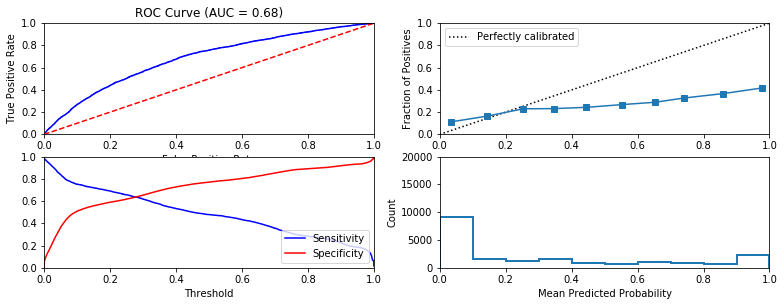

Brier score: 0.21974233457966494
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.6271087]


In [285]:
## Train and test a naive bayes classifier
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                          cv_parameters = {},
                          model_name = "Naive Bayes",
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### $l_1$ regularized logistic regression

  Model: Logistic Regression l1
Fit time: 103.76 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.47315130850327913
Accuracy:  0.61615
              precision    recall  f1-score   support

  No default     0.8817    0.5960    0.7112     15863
     Default     0.3092    0.6935    0.4277      4137

    accuracy                         0.6161     20000
   macro avg     0.5955    0.6447    0.5695     20000
weighted avg     0.7633    0.6161    0.6526     20000



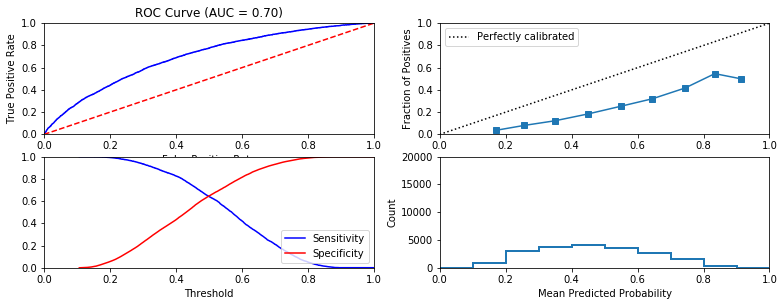

Brier score: 0.22048030786033024
Were parameters on edge? : False
Score variations around CV search grid : 22.667951352470652
[0.49997891 0.49995783 0.62177429 0.64650793 0.64254374 0.64201664
 0.64216426 0.64205883 0.64205883 0.64203775]


In [293]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = 'balanced')
cv_parameters = {'C' : [10.**c for c in np.arange(-5., 5.)]}

l1_logistic = fit_classification(l1_logistic, data_dict,
                          cv_parameters, 'Logistic Regression l1', default_seed,
                          output_to_file = True, print_to_screen = True)

### $l_2$ regularized logistic regression

  Model: Logistic Regression l2
Fit time: 5.74 seconds
Optimal parameters:
{'C': 10000.0}

Accuracy-maximizing threshold was: 0.43211176812806396
Accuracy:  0.55915
              precision    recall  f1-score   support

  No default     0.8966    0.5020    0.6437     15863
     Default     0.2895    0.7781    0.4220      4137

    accuracy                         0.5592     20000
   macro avg     0.5931    0.6401    0.5329     20000
weighted avg     0.7711    0.5592    0.5978     20000



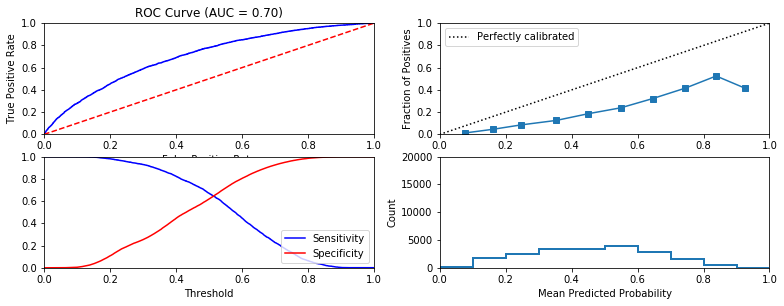

Brier score: 0.22055203795283837
Were parameters on edge? : True
Score variations around CV search grid : 2.3717463697404852
[0.62057259 0.62839533 0.63543789 0.63366653 0.63307607 0.63450993
 0.63537444 0.6356064  0.63556422 0.63564857]


In [341]:
## Train and test a l_1 regularized logistic regression classifier
l2_logistic = LogisticRegression(random_state = 0, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')
cv_parameters = {'C' : [10.**c for c in np.arange(-5., 5.)]}

l2_logistic = fit_classification(l2_logistic, data_dict,
                          cv_parameters, 'Logistic Regression l2', default_seed,
                          output_to_file = True,
                          print_to_screen = True)

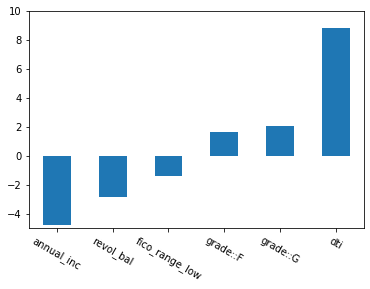

In [342]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 7.3 seconds
Optimal parameters:
{'max_depth': 8}

Accuracy-maximizing threshold was: 0.53125
Accuracy:  0.7816
              precision    recall  f1-score   support

  No default     0.8126    0.9419    0.8725     15863
     Default     0.4284    0.1670    0.2403      4137

    accuracy                         0.7816     20000
   macro avg     0.6205    0.5545    0.5564     20000
weighted avg     0.7331    0.7816    0.7417     20000



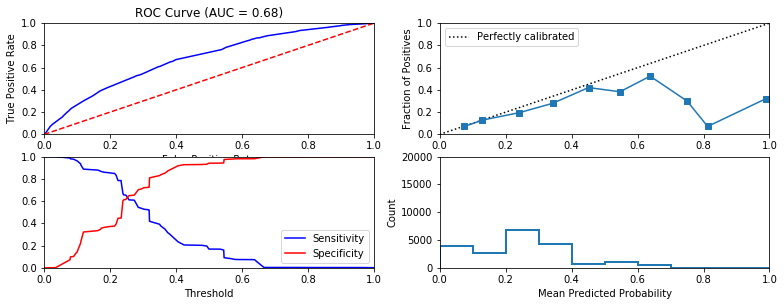

Brier score: 0.15667022735023392
Were parameters on edge? : False
Score variations around CV search grid : nan
[       nan 0.73522042 0.80358237 0.79523147 0.78595304]


In [302]:
## Train and test a decision tree classifier
decision_tree = DecisionTreeClassifier()
cv_parameters =  {'max_depth':range(0, 20, 4)}

decision_tree = fit_classification(decision_tree,data_dict,cv_parameters,model_name='Decision Tree')

### Random forest

  Model: Random forest
Fit time: 97.82 seconds
Optimal parameters:
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 8}

Accuracy-maximizing threshold was: 0.5099606791745509
Accuracy:  0.7325
              precision    recall  f1-score   support

  No default     0.8333    0.8284    0.8309     15863
     Default     0.3567    0.3648    0.3607      4137

    accuracy                         0.7325     20000
   macro avg     0.5950    0.5966    0.5958     20000
weighted avg     0.7347    0.7325    0.7336     20000



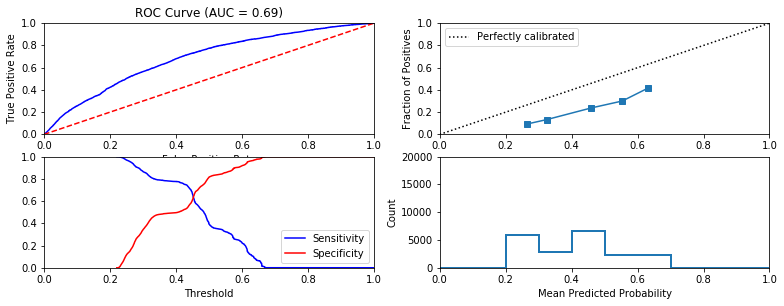

Brier score: 0.1955400251899574
Were parameters on edge? : True
Score variations around CV search grid : 4.805103034571248
[0.73243572 0.72785965 0.73091739 0.72229378 0.7143642  0.72410649
 0.74626899 0.75042279 0.74306376 0.74622663 0.74911545 0.74500377]


In [282]:
## Train and test a random forest classifier
random_forest = RandomForestClassifier(bootstrap = True)
cv_parameters = {
    'max_depth': [2, 3],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [4, 8, 12],
}

random_forest = fit_classification(random_forest,data_dict,cv_parameters, 'Random forest')

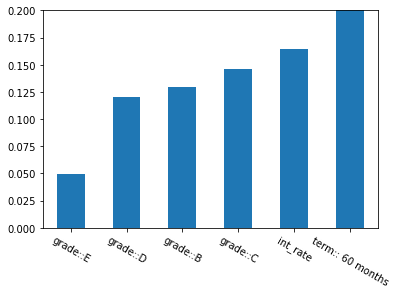

In [283]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer perceptron
Fit time: 386.73 seconds
Optimal parameters:
{'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'learning_rate_init': 0.005, 'solver': 'sgd'}

Accuracy-maximizing threshold was: 0.42924071692144117
Accuracy:  0.7773
              precision    recall  f1-score   support

  No default     0.8174    0.9261    0.8684     15863
     Default     0.4218    0.2067    0.2774      4137

    accuracy                         0.7773     20000
   macro avg     0.6196    0.5664    0.5729     20000
weighted avg     0.7356    0.7773    0.7461     20000



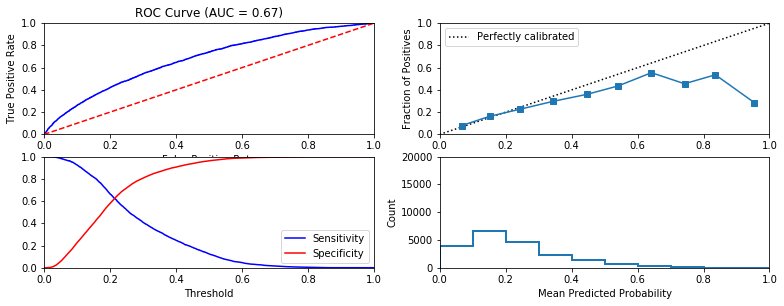

Brier score: 0.155364454319975
Were parameters on edge? : True
Score variations around CV search grid : 37.57889311550796
[0.73203723 0.75887912 0.76155745 0.61913734 0.55634113 0.49926191
 0.63056375 0.50191882 0.7933128  0.78601793 0.78981261 0.77184747
 0.79145725 0.79015096 0.78768352 0.79982868]


In [289]:
## Train and test a multi-layer perceptron classifier
mlp = MLPClassifier(early_stopping = True)
cv_parameters = {'activation':['logistic', 'tanh'],
                 'hidden_layer_sizes':[(10,20),(10,10,10)],
                 'solver':['lbfgs', 'sgd'],
                 'learning_rate_init':[0.01, 0.005]
                }

mlp = fit_classification(mlp, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = "Multi-layer perceptron",
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

## Train and Test logistic regression model with features derived by LendingClub

  Model: Logistic Regression l1
Fit time: 8.31 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.5383852280571132
Accuracy:  0.7192
              precision    recall  f1-score   support

  No default     0.8430    0.7938    0.8177     15863
     Default     0.3539    0.4332    0.3896      4137

    accuracy                         0.7192     20000
   macro avg     0.5985    0.6135    0.6036     20000
weighted avg     0.7418    0.7192    0.7291     20000



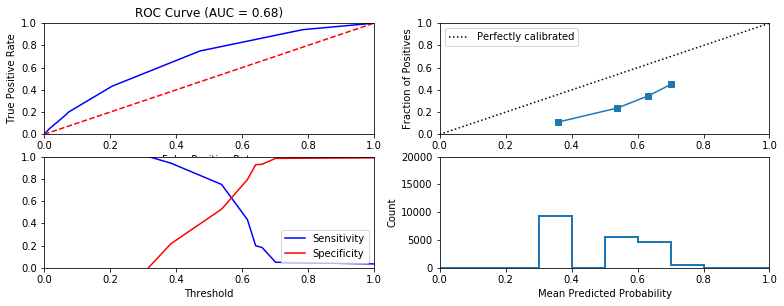

Brier score: 0.22724706346105963
Were parameters on edge? : False
Score variations around CV search grid : 20.791749490698
[0.49997891 0.49997891 0.53945177 0.63122075 0.63122075 0.63122075
 0.63122075 0.63122075 0.63122075 0.63122075]


In [202]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['grade']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = 'balanced')
cv_parameters = {'C' : [10.**c for c in np.arange(-5., 5.)]}


lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict,
                          cv_parameters, 'Logistic Regression l1', default_seed,
                          output_to_file = False, print_to_screen = True)

  Model: Logistic Regression l2
Fit time: 1.33 seconds
Optimal parameters:
{'C': 1e-05}

Accuracy-maximizing threshold was: 0.5003986519006007
Accuracy:  0.57365
              precision    recall  f1-score   support

  No default     0.8847    0.5317    0.6643     15863
     Default     0.2903    0.7343    0.4161      4137

    accuracy                         0.5736     20000
   macro avg     0.5875    0.6330    0.5402     20000
weighted avg     0.7618    0.5736    0.6129     20000



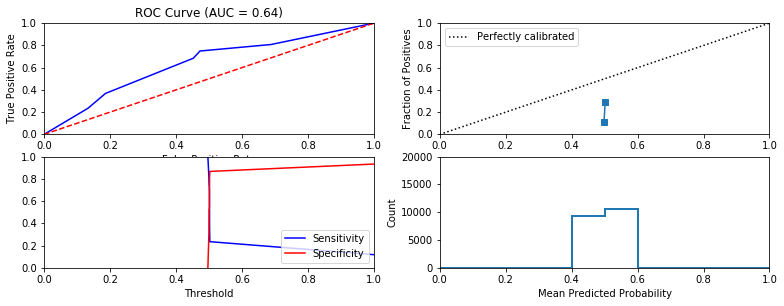

Brier score: 0.2497335318320606
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.63122075 0.63122075 0.63122075 0.63122075 0.63122075 0.63122075
 0.63122075 0.63122075 0.63122075 0.63122075]


In [203]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(random_state = 0, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')


lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict,
                          cv_parameters, 'Logistic Regression l2', default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### Average Performance

split train and test using random seed

In [306]:
def iterate_times(model, cv_parameters = {},
                          model_name = None):
    if model_name != None:
        print("=========================================================")
        print("  Model: " + model_name)
        print("=========================================================")
    recall_s = []
    for i in range(20):
        data_dict = prepare_data(feature_subset = your_features,random_state = i)
        
        X_train = data_dict['X_train']
        y_train = data_dict['y_train']

        X_test = data_dict['X_test']
        y_test = data_dict['y_test']

        filter_train = data_dict['train_set']   

        cv_model = GridSearchCV(model, cv_parameters)

        cv_model.fit(X_train, y_train)

        best_model = cv_model.best_estimator_



        try:
            y_pred_probs = best_model.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

            probs_predicted = True
        except:
            probs_predicted = False

        
        if probs_predicted:
            y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
            fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

            true_pos_train = tpr_train*(y_train.sum())
            true_neg_train = (1 - fpr_train) *(1-y_train).sum()

            best_threshold_index = np.argmax(true_pos_train + true_neg_train)
            best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]

            y_pred = (y_pred_probs > best_threshold)
        else:
            y_pred = best_model.predict(X_test)

        recall_s.append(recall_score(y_test, y_pred))
    
    print("average_recall: ", np.mean(recall_s))
    print("var_recall: ", np.var(recall_s))


## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [308]:
## removed features
your_features = ['term', 'revol_bal', 'revol_util', 'dti', 
                 'loan_amnt', 'annual_inc', 'open_acc','pub_acc','delinq_2yrs', 'int_rate']

In [309]:
# Naive Bayes
gnb = GaussianNB()
iterate_times(gnb,model_name ="Naive Bayes")

  Model: Naive Bayes
average_recall:  0.6525135129100241
var_recall:  0.0006561882402257345


In [310]:
l1_logistic = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = 'balanced')
cv_parameters = {'C' : [10.**c for c in np.arange(-5., 5.)]}

iterate_times(l1_logistic, model_name ="Logistic Regression l1")

  Model: Logistic Regression l1
average_recall:  0.6980373374379985
var_recall:  0.000441107898404425


In [311]:
l2_logistic = LogisticRegression(random_state = 0, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')
cv_parameters = {'C' : [10.**c for c in np.arange(-5., 5.)]}
iterate_times(l2_logistic, model_name ="Logistic Regression l2")

  Model: Logistic Regression l2
average_recall:  0.6955114411947482
var_recall:  0.0004770633489177607


In [312]:
decision_tree = DecisionTreeClassifier()
cv_parameters =  {'max_depth':range(0, 20, 4)}

iterate_times(decision_tree, model_name ="Decision Tree")

  Model: Decision Tree
average_recall:  0.0
var_recall:  0.0


In [313]:
random_forest = RandomForestClassifier(bootstrap = True)
cv_parameters = {
    'max_depth': [2, 3],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [4, 8, 12],
}
iterate_times(random_forest, model_name ="Random Forest")

  Model: Random Forest
average_recall:  0.19752373936647546
var_recall:  0.0009221167025795602


In [314]:
mlp = MLPClassifier(early_stopping = True, solver = 'sgd', activation = 'tanh')
cv_parameters = {
                 'hidden_layer_sizes':[(10,20),(10,10,10)],
                 'learning_rate_init':[0.01, 0.005]
                }
iterate_times(mlp, model_name = "Multi-layer perceptron")

  Model: Multi-layer perceptron
average_recall:  0.6424446426660209
var_recall:  0.004300573742120851


## Time stability test of MODEL

  Model: Logistic Regression l2
Fit time: 35.77 seconds
Optimal parameters:
{'C': 2.7825594022071245}

Accuracy-maximizing threshold was: 0.4389488026502584
Accuracy:  0.57815
              precision    recall  f1-score   support

  No default     0.8953    0.5301    0.6659     15863
     Default     0.2973    0.7624    0.4278      4137

    accuracy                         0.5782     20000
   macro avg     0.5963    0.6462    0.5469     20000
weighted avg     0.7716    0.5782    0.6167     20000



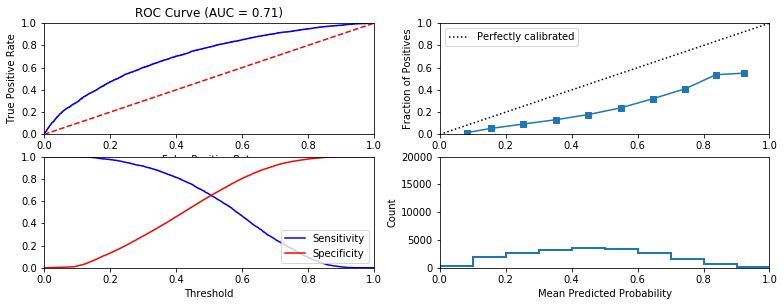

Brier score: 0.21741512664474943
Were parameters on edge? : False
Score variations around CV search grid : 0.10171379267799861
[0.64214318 0.64262813 0.64231186 0.64220644 0.64199557 0.64197449
 0.64201666 0.64205884 0.64205884 0.64205884]


{'model': LogisticRegression(C=2.7825594022071245, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'y_pred_labels': array([False, False,  True, ...,  True,  True,  True]),
 'y_pred_probs': array([0.12866121, 0.28977189, 0.57471494, ..., 0.51209044, 0.49944396,
        0.76882934])}

In [288]:
## Define the time window of train and test data
from datetime import datetime
start_date_train = datetime.strptime('2010-01-01','%Y-%m-%d').date()
end_date_train = datetime.strptime('2010-12-31','%Y-%m-%d').date()
start_date_test = datetime.strptime('2018-01-01','%Y-%m-%d').date()
end_date_test = datetime.strptime('2018-12-31','%Y-%m-%d').date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 7000, feature_subset = your_features)

## Train and test MODEL using this data
cv_parameters = {'C' : [c for c in np.logspace(0, 4, 10)]}
l2_logistic = LogisticRegression(random_state = 0, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')
fit_classification(l2_logistic, data_dict,
                   cv_parameters, 'Logistic Regression l2', default_seed,
                   output_to_file = True,
                   print_to_screen = True)

  Model: Logistic Regression l2
Fit time: 8.16 seconds
Optimal parameters:
{'C': 3593.813663804626}

Accuracy-maximizing threshold was: 0.4318841354349022
Accuracy:  0.5587
              precision    recall  f1-score   support

  No default     0.8966    0.5014    0.6432     15863
     Default     0.2893    0.7783    0.4219      4137

    accuracy                         0.5587     20000
   macro avg     0.5930    0.6399    0.5325     20000
weighted avg     0.7710    0.5587    0.5974     20000



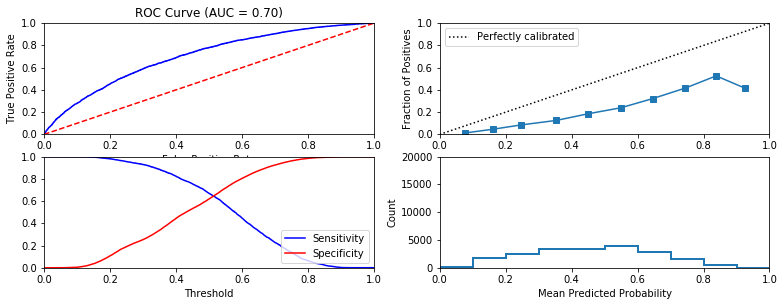

Brier score: 0.22055185739589186
Were parameters on edge? : False
Score variations around CV search grid : 0.17913007188433955
[0.63450993 0.63491056 0.6354377  0.63541662 0.6356064  0.63554314
 0.63554314 0.63556422 0.63564857 0.63564857]


{'model': LogisticRegression(C=3593.813663804626, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'y_pred_labels': array([False, False,  True, ...,  True,  True,  True]),
 'y_pred_probs': array([0.17321231, 0.22678539, 0.63958585, ..., 0.47338515, 0.60214222,
        0.56561352])}

In [343]:
## Define the time window of  train and test data
from datetime import datetime
start_date_train = datetime.strptime('2017-01-01','%Y-%m-%d').date()
end_date_train = datetime.strptime('2017-12-31','%Y-%m-%d').date()
start_date_test = datetime.strptime('2018-01-01','%Y-%m-%d').date()
end_date_test = datetime.strptime('2018-12-31','%Y-%m-%d').date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
cv_parameters = {'C' : [c for c in np.logspace(0, 4, 10)]}
l2_logistic = LogisticRegression(random_state = 0, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')
fit_classification(l2_logistic, data_dict,
                   cv_parameters, 'Logistic Regression l2', default_seed,
                   output_to_file = True,
                   print_to_screen = True)

## Train and test MODEL on the original data

In [286]:
## define set of features to use in different models
your_features = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 
                'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status','purpose', 
                'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high', 
                'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt','last_pymnt_d', 'recoveries']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

  Model: Logistic Regression l2
Fit time: 37.45 seconds
Optimal parameters:
{'C': 2.7825594022071245}

Accuracy-maximizing threshold was: 0.4389488026502584
Accuracy:  0.57815
              precision    recall  f1-score   support

  No default     0.8953    0.5301    0.6659     15863
     Default     0.2973    0.7624    0.4278      4137

    accuracy                         0.5782     20000
   macro avg     0.5963    0.6462    0.5469     20000
weighted avg     0.7716    0.5782    0.6167     20000



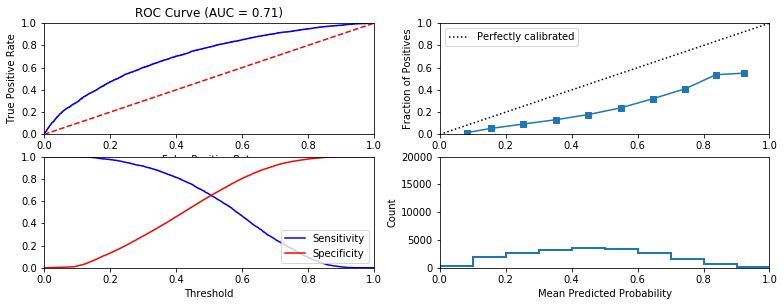

Brier score: 0.21741512664474943
Were parameters on edge? : False
Score variations around CV search grid : 0.10171379267799861
[0.64214318 0.64262813 0.64231186 0.64220644 0.64199557 0.64197449
 0.64201666 0.64205884 0.64205884 0.64205884]


{'model': LogisticRegression(C=2.7825594022071245, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'y_pred_labels': array([False, False,  True, ...,  True,  True,  True]),
 'y_pred_probs': array([0.12866121, 0.28977189, 0.57471494, ..., 0.51209044, 0.49944396,
        0.76882934])}

In [287]:
## Train and test MODEL using this data
cv_parameters = {'C' : [c for c in np.logspace(0, 4, 10)]}
l2_logistic = LogisticRegression(random_state = 0, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')
fit_classification(l2_logistic, data_dict,
                   cv_parameters, 'Logistic Regression l2', default_seed,
                   output_to_file = True,
                   print_to_screen = True)

## Test regression models

In [159]:
def fit_regression(model, data_dict, data,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [163]:
# old
def prepare_data_old(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [346]:
## define set of features to use in different models
your_features = ['term', 'grade', 'fico_range_low', 'revol_bal', 'revol_util', 'dti', 
                 'loan_amnt', 'annual_inc', 'open_acc','pub_acc','delinq_2yrs', 'int_rate']
# prepare the train, test data for training models
data_dict = prepare_data_old(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### $l_1$ regularized linear regression

In [179]:
## First, trying l1 regularized linear regression with hyper-parameters
cv_parameters = {'alpha':[0.001,0.005,0.01,0.05]}

reg_lasso = fit_regression(linear_model.Lasso(),data_dict, data, cv_parameters = cv_parameters,model_name = 'l1 regression')

# separate default and non-default
reg_lasso_sep = fit_regression(linear_model.Lasso(),data_dict, data, cv_parameters = cv_parameters, 
                           separate= True, model_name = 'l1 regression')


  Model: l1 regression  Return column: ret_PESS
Fit time: 0.22 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.0072546175953785985
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -16.763793139016006
All test scores : [-0.02895186 -0.03380529 -0.03380529 -0.03380529]
  Model: l1 regression  Return column: ret_OPT
Fit time: 0.13 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.0037694303928902384
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -117.66539988460897
All test scores : [-0.00331936 -0.0072251  -0.0072251  -0.0072251 ]
  Model: l1 regression  Return column: ret_INTa
Fit time: 0.15 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.009100809953630384
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -39.3594617447585
All test scores : [-0.02082903 -0.02902723 -0.02902723 -0.02902723]
  Model: l1 regression  Retur

### $l_2$ regularized linear regressor

In [326]:
## trying l2 regularized linear regression with hyper-parameters
cv_parameters = {'alpha':[0.001,0.005,0.01,0.05]}
reg_ridge = fit_regression(linear_model.Ridge(), data_dict, data,
                           cv_parameters = cv_parameters,model_name = 'l2 regression')
reg_ridge_sep = fit_regression(linear_model.Ridge(), data_dict, data,separate = True,
                           cv_parameters = cv_parameters,model_name = 'l2 regression')

  Model: l2 regression  Return column: ret_PESS
Fit time: 0.17 seconds
Optimal parameters:
{'alpha': 0.05}

Testing r2 score: 0.027180290186982092
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0445635545560777
All test scores : [-0.02332879 -0.02332792 -0.02332685 -0.0233184 ]
  Model: l2 regression  Return column: ret_OPT
Fit time: 0.1 seconds
Optimal parameters:
{'alpha': 0.05}

Testing r2 score: 0.01265603756236977
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 0.08474804694417895
All test scores : [0.00765922 0.00765977 0.00766044 0.00766572]
  Model: l2 regression  Return column: ret_INTa
Fit time: 0.11 seconds
Optimal parameters:
{'alpha': 0.05}

Testing r2 score: 0.029763440789268736
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.06662495631115543
All test scores : [-0.01585239 -0.01585151 -0.01585042 -0.01584184]
  Model: l2 regression  Return column

### Multi-layer perceptron regressor

In [318]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {'alpha':[0.0001,0.0005,0.001,0.005],
                'hidden_layer_sizes':[(10,10,10),(20,20,20)]}
reg_mlp = fit_regression(MLPRegressor(),data_dict, data,
                         cv_parameters = cv_parameters,model_name = 'Multi-layer perceptron regressor')              
reg_mlp_sep = fit_regression(MLPRegressor(),data_dict, data, separate = True,
                         cv_parameters = cv_parameters,model_name = 'Multi-layer perceptron regressor')  

  Model: Multi-layer perceptron regressor  Return column: ret_PESS
Fit time: 40.2 seconds
Optimal parameters:
{'alpha': 0.001, 'hidden_layer_sizes': (20, 20, 20)}

Testing r2 score: 0.021974953271028164
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -190.47547156528705
All test scores : [-0.03625323 -0.02284373 -0.01958506 -0.02368591 -0.02247565 -0.01568427
 -0.04437826 -0.04555895]
  Model: Multi-layer perceptron regressor  Return column: ret_OPT
Fit time: 41.03 seconds
Optimal parameters:
{'alpha': 0.005, 'hidden_layer_sizes': (20, 20, 20)}

Testing r2 score: 0.010742246354766172
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 325.1275532026365
All test scores : [-0.01334828  0.00056052 -0.0009335  -0.00314821 -0.00148225 -0.00701402
  0.00337525  0.00592921]
  Model: Multi-layer perceptron regressor  Return column: ret_INTa
Fit time: 39.37 seconds
Optimal parameters:
{'alpha': 0.005, 'hidden_layer_size

### Random forest regressor

In [320]:
## trying random forest regression with hyper-parameters

random_forest_regressor = RandomForestRegressor(bootstrap =True )
cv_parameters = {
    'max_depth': [1,2,3],
    'max_features': [2,3],
    'min_samples_leaf': [1,2]
}

reg_rf = fit_regression(random_forest_regressor,data_dict,data ,cv_parameters = cv_parameters,model_name = 'Random forest regressor')
reg_rf_sep = fit_regression(random_forest_regressor,data_dict,data, separate = True, cv_parameters = cv_parameters,model_name = 'Random forest regressor')


  Model: Random forest regressor  Return column: ret_PESS
Fit time: 25.34 seconds
Optimal parameters:
{'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2}

Testing r2 score: 0.017606393960444833
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -41.797970168018786
All test scores : [-0.02987766 -0.02970102 -0.02846059 -0.02880908 -0.02609709 -0.02557514
 -0.024759   -0.0246186  -0.02302895 -0.02233591 -0.0214955  -0.02107058]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 25.38 seconds
Optimal parameters:
{'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2}

Testing r2 score: 0.007786274941369853
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 575.9357003626868
All test scores : [-4.60882184e-03 -4.75139705e-03 -4.26861421e-03 -4.03611300e-03
 -2.87468138e-03 -2.87316946e-03 -1.17353635e-03 -1.49626891e-03
  6.18184734e-05 -2.52495767e-04  6.90220316e-04  9.98327516e-04]
  Mode

## Average Performance

In [349]:
#train L1 lasso regression over 20 iterations 
cv_parameters = {'alpha':[0.001,0.005,0.01,0.05]}
def iterate_regression(model,data_dict,cv_parameters = {},model_name = 'l1 lasso regression'):
    M1_return_list = []
    M2_return_list = []
    M3_1_return_list = []
    M3_2_return_list = []
    for i in range(20):
        out = fit_regression(model, data_dict,data, cv_parameters = cv_parameters,model_name = 'l2 regression',random_state = i,output_to_file = False,
                      print_to_screen = False)
        M1_return_list.append(out['ret_PESS']['predicted_return'])
        M2_return_list.append(out['ret_OPT']['predicted_return'])
        M3_1_return_list.append(out['ret_INTa']['predicted_return'])
        M3_2_return_list.append(out['ret_INTb']['predicted_return'])
    print(model_name)
    print(model_name,": M1", np.mean(M1_return_list))
    print(model_name,": M2", np.mean(M2_return_list))
    print(model_name,": M3_1", np.mean(M3_1_return_list))
    print(model_name,": M3_2", np.mean(M3_2_return_list))
    
iterate_regression(linear_model.Lasso(),data_dict,cv_parameters)

l1 lasso regression
l1 lasso regression : M1 0.0025217259286631783
l1 lasso regression : M2 0.05119559658855016
l1 lasso regression : M3_1 0.02142928088845009
l1 lasso regression : M3_2 0.057114793950140276


In [348]:
iterate_regression(linear_model.Ridge(),data_dict,cv_parameters, model_name= 'l2 ridge regression')

l2 ridge regression
l2 ridge regression : M1 0.002426492826195855
l2 ridge regression : M2 0.0513069168515462
l2 ridge regression : M3_1 0.021373475399633718
l2 ridge regression : M3_2 0.05707536367445411


## Test investment strategies 
Now we test several investment strategies using the learning models above

In [82]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. 
                   Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. 
                   Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. 
                   Rank the loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            filter_random = ( np.array([True]*len(data_test)) )
    
            filter_random[ np.random.choice( np.where(filter_random)[0], size = filter_random.sum() - num_loans, replace = False ) ] = False
        
            pf_test = data_test[filter_random]

            ## Find the average return for these loans
            ret_test = (pf_test[ret_col]).mean() 

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            filter_return = ( np.array([True]*len(data_test)) )
    
            filter_return[ np.random.choice( np.where(filter_return)[0], size = filter_return.sum() - num_loans, replace = False ) ] = False
        
            pf_test = data_test[filter_return]

            ## Find their return
            ret_test = (pf_test[ret_col]).mean() 

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            filter_default = ( np.array([True]*len(data_test)) )
    
            filter_default[ np.random.choice( np.where(filter_default)[0], size = filter_default.sum() - num_loans, replace = False ) ] = False
        
            pf_test = data_test[filter_default]


            ## Find the average return for these loans
            ret_test = (pf_test[ret_col]).mean() 

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            filter_default_return = ( np.array([True]*len(data_test)) )
    
            filter_default_return[ np.random.choice( np.where(filter_default_return)[0], size = filter_default_return.sum() - num_loans, replace = False ) ] = False
        
            pf_test = data_test[filter_default_return]

            ## Find their return
            ret_test = (pf_test[ret_col]).mean() 

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [322]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.0009176372699830927
ret_OPT: 0.04802793795592395
ret_INTa: 0.020809838944401984
ret_INTb: 0.05419052027745449


In [175]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict,
                        classifier = l2_logistic,
                        regressor = None,
                        strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.0012334708584617595
ret_OPT: 0.055102983425144574
ret_INTa: 0.02110515117541611
ret_INTb: 0.05957128090701439


In [180]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict,
                        classifier = l2_logistic,
                        regressor = reg_lasso,
                        strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.003699972903139338
ret_OPT: 0.051572578138624134
ret_INTa: 0.022470156807172428
ret_INTb: 0.05542925408255487


In [334]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'alpha':[0.001,0.005,0.01,0.05]}

reg_separate = fit_regression(linear_model.Ridge(), data_dict, data,
                           cv_parameters = cv_parameters, separate = True, model_name = 'l2 regression',print_to_screen = False)

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict,
                        classifier = l2_logistic,
                        regressor = reg_separate,
                        strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)
print()
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-return-based

ret_PESS: 0.002190263305258665
ret_OPT: 0.05370419525997517
ret_INTa: 0.01746281755343527
ret_INTb: 0.058290128090001794


## Sensitivity test of portfolio size

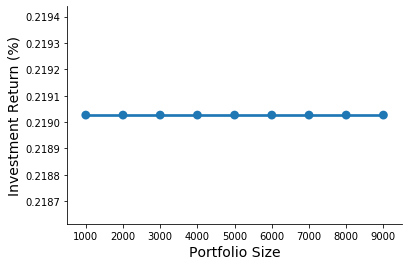

In [339]:
## Test the best-performing data-driven strategy on different portfolio sizes
test_strategy = 'Default-return-based'
result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict,
                        classifier = l2_logistic,
                        regressor = reg_separate,
                        strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()